In [1]:
import SimpleITK as sitk
import numpy as np

CT_data = sitk.ReadImage("transformed_steal_real_v2.nii")
paut = sitk.ReadImage("Edge_Cropped_1_padded_left_gray_V2.nii")



# Get the size, origin, and spacing for CT_data
CT_size = CT_data.GetSize()
CT_origin = CT_data.GetOrigin()
CT_spacing = CT_data.GetSpacing()

# Get the size, origin, and spacing for paut
paut_size = paut.GetSize()
paut_origin = paut.GetOrigin()
paut_spacing = paut.GetSpacing()

# Print the details
print("CT Data:")
print("Size:", CT_size)
print("Origin:", CT_origin)
print("Spacing:", CT_spacing)

print("\nPAUT Data:")
print("Size:", paut_size)
print("Origin:", paut_origin)
print("Spacing:", paut_spacing)

CT Data:
Size: (1057, 1999, 1057)
Origin: (0.0, 0.0, 0.0)
Spacing: (1.0, 1.0, 1.0)

PAUT Data:
Size: (133, 321, 49)
Origin: (347.55230712890625, 227.59173583984375, 365.5378723144531)
Spacing: (1.2000000476837158, 4.2270002365112305, 7.099999904632568)


In [2]:
def resample_image_to_reference(input_image, reference_image):
    """
    Resample the input_image to match the reference_image's physical space.
    """
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference_image)
    resample.SetInterpolator(sitk.sitkLinear)  # Use linear interpolation
    resample.SetDefaultPixelValue(0)  # Value for out-of-bounds pixels
    resample.SetOutputOrigin(reference_image.GetOrigin())
    resample.SetOutputSpacing(reference_image.GetSpacing())
    resample.SetSize(reference_image.GetSize())
    resample.SetOutputDirection(reference_image.GetDirection())
    return resample.Execute(input_image)

# Resample the PAUT image to match the CT image
resampled_paut = resample_image_to_reference(paut, CT_data)
paut_size = resampled_paut.GetSize()
paut_origin = resampled_paut.GetOrigin()
paut_spacing = resampled_paut.GetSpacing()

print(paut_size)
print(paut_origin)
print(paut_spacing)



(1057, 1999, 1057)
(0.0, 0.0, 0.0)
(1.0, 1.0, 1.0)


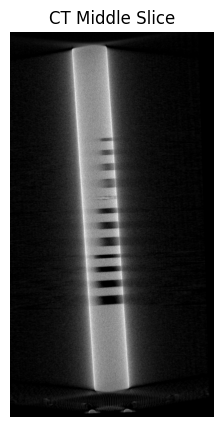

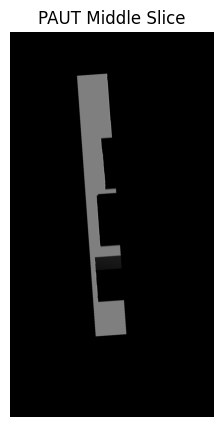

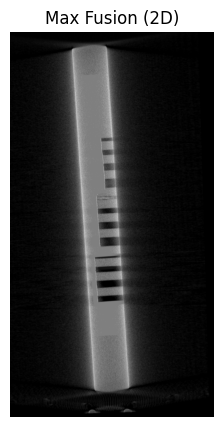

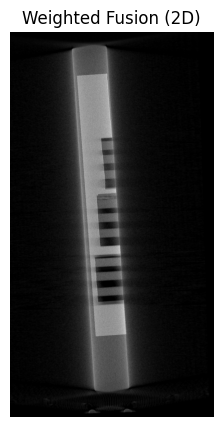

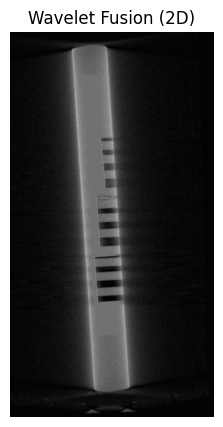

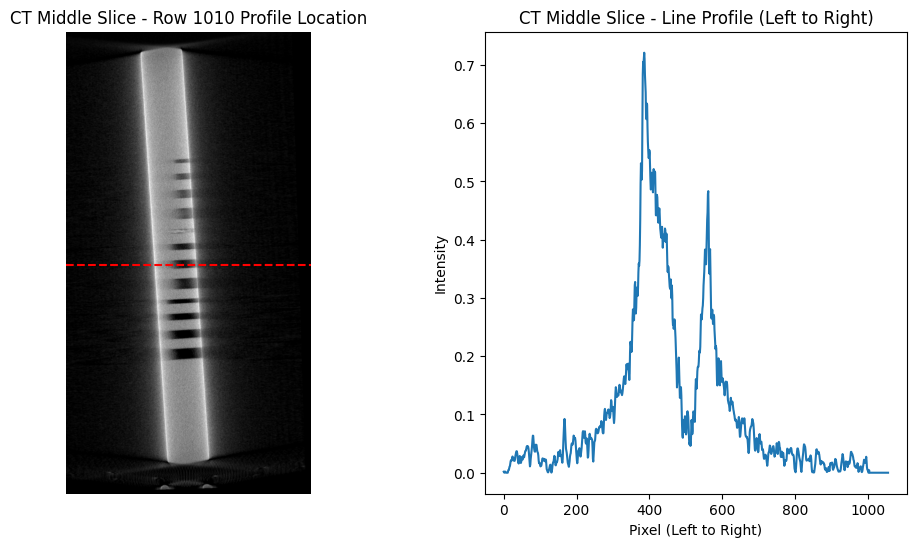

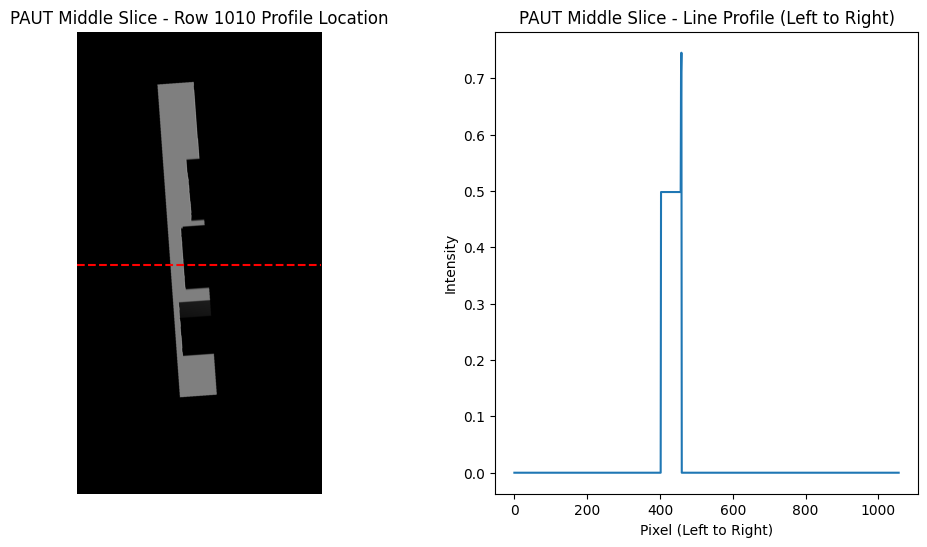

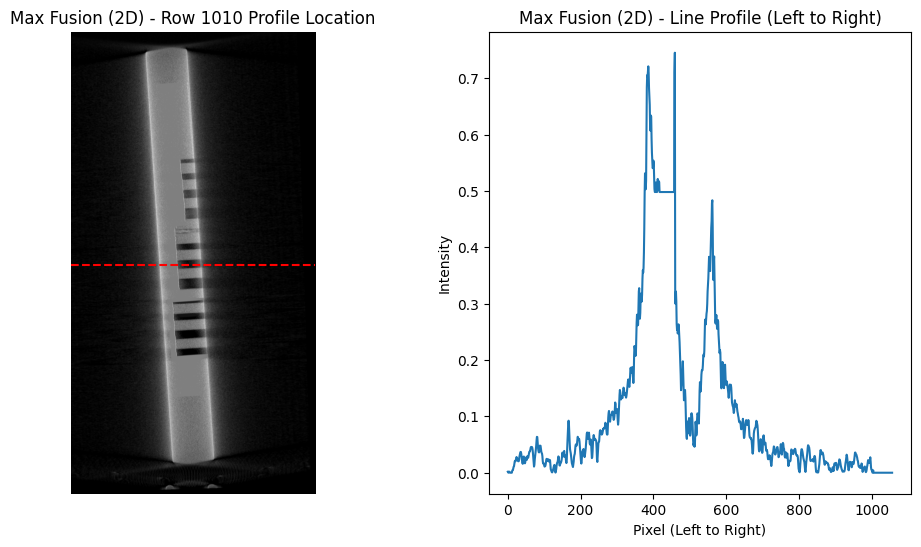

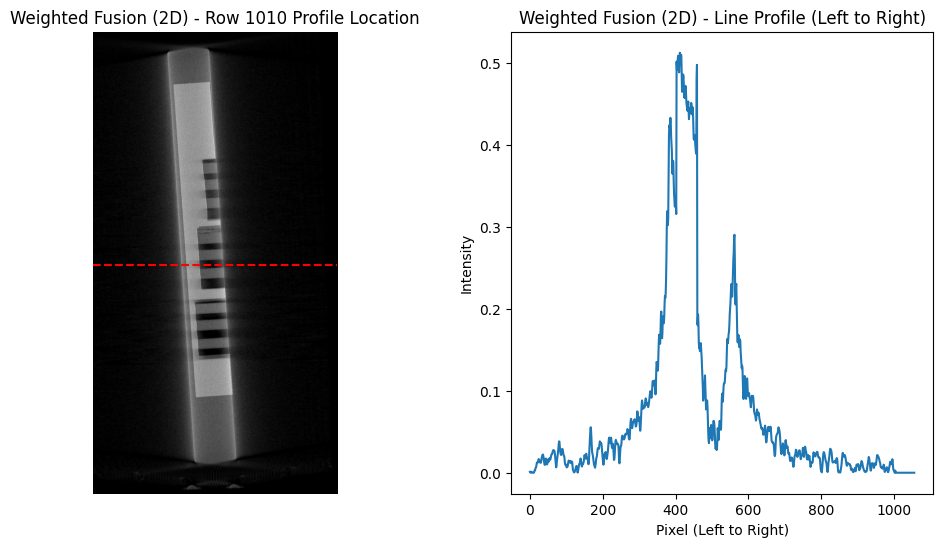

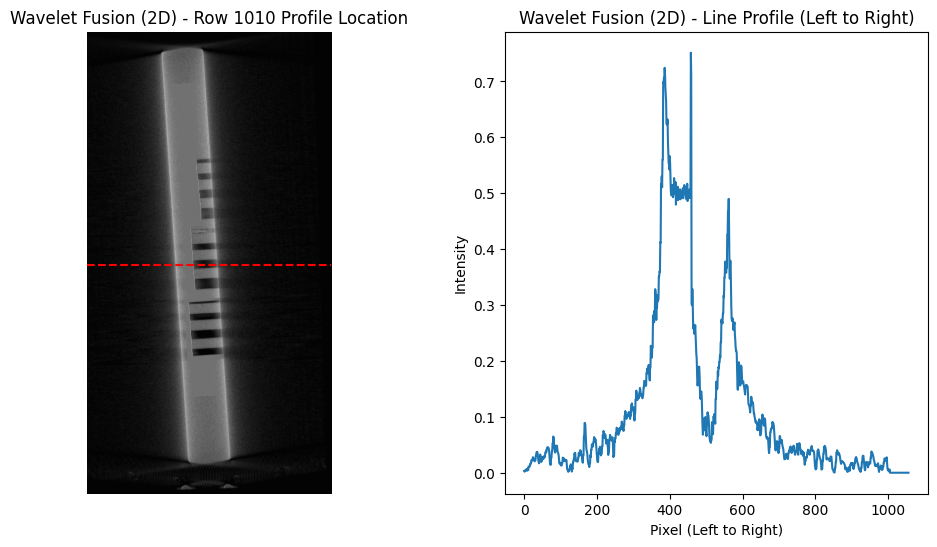

In [3]:
import SimpleITK as sitk
import numpy as np
import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    This returns a 2D image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    # Set the size for the extraction: full in x and y, but 0 in the z-direction.
    size[2] = 0  
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

def normalize_image(image, out_type=sitk.sitkFloat32):
    """
    Normalize image intensities to the range [0,1] and cast to a given pixel type.
    Using a consistent pixel type (e.g., Float32) for all images prevents mismatches in fusion.
    """
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    normalized_img = sitk.GetImageFromArray(array)
    normalized_img.CopyInformation(image)
    return sitk.Cast(normalized_img, out_type)

def cast_to_int(image, pixel_type=sitk.sitkUInt16):
    """Cast image to integer type (UInt16) for compatibility with Mask operations."""
    return sitk.Cast(image, pixel_type)
    
def maximum_fusion(ct_image, paut_image):
    """Apply pixel-wise maximum fusion (both images must be the same size & type)."""
    return sitk.Maximum(ct_image, paut_image)

def weighted_fusion(ct_image, paut_image, alpha=0.6):
    """Apply weighted averaging fusion: output = alpha * CT + (1-alpha) * PAUT"""
    return sitk.Add(
        sitk.Multiply(ct_image, alpha),
        sitk.Multiply(paut_image, (1 - alpha))
    )

def adjust_image_to_reference(image, reference):
    """
    Adjusts a SimpleITK image by cropping it if necessary so that its size matches the reference image.
    This function assumes the image is slightly larger than the reference.
    """
    ref_size = reference.GetSize()
    img_size = image.GetSize()
    # Calculate the difference in each dimension
    diff = [img_size[i] - ref_size[i] for i in range(len(ref_size))]
    # If the image is larger, crop the extra pixels from the bottom/right
    if any(d > 0 for d in diff):
        # For 2D images, diff is a 2-element list.
        image = sitk.Crop(image, [0, 0], diff)
    return image

def wavelet_fusion(ct_image, paut_image, wavelet='haar'):
    """Wavelet-based fusion using maximum selection of wavelet coefficients."""
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)

    # Wavelet decomposition on 2D arrays
    coeffs_ct = pywt.dwtn(ct_array, wavelet)
    coeffs_paut = pywt.dwtn(paut_array, wavelet)

    # Fusion by maximum selection of coefficients
    fused_coeffs = {}
    for key in coeffs_ct.keys():
        fused_coeffs[key] = np.maximum(coeffs_ct[key], coeffs_paut[key])

    # Inverse wavelet transform to get the fused array
    fused_array = pywt.idwtn(fused_coeffs, wavelet)

    # Convert back to a SimpleITK image
    fused_img = sitk.GetImageFromArray(fused_array)
    # Adjust fused image size to match the reference (ct_image) size if necessary
    fused_img = adjust_image_to_reference(fused_img, ct_image)
    # Now copy the spatial metadata from the reference image
    fused_img.CopyInformation(ct_image)
    return fused_img

def display_image(image, title='Fused 2D Slice'):
    """
    Display a 2D SimpleITK image (assumed shape [y, x]).
    """
    array_2d = sitk.GetArrayFromImage(image)
    plt.figure(figsize=(5,5))
    plt.imshow(array_2d, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_line_profile(image, label, row_index=1010, save_path=None):
    """
    Plot the line profile from left to right for the specified row of a 2D image.
    The function overlays a horizontal line on the image at the specified row and
    plots the intensity profile extracted from that row.
    """
    array = sitk.GetArrayFromImage(image)
    # Ensure the row index is within the image bounds
    if row_index >= array.shape[0]:
        raise ValueError("Row index is out of bounds for the given image.")
    
    # Extract the profile along the given row (left to right)
    line_profile = array[row_index, :]

    # Create a figure with two subplots: one showing the image with the profile line and one for the profile plot.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image with the horizontal line at the specified row
    axs[0].imshow(array, cmap='gray')
    axs[0].axhline(y=row_index, color='red', linestyle='--')
    axs[0].set_title(f"{label} - Row {row_index} Profile Location")
    axs[0].axis('off')

    # Plot the intensity profile along that row
    axs[1].plot(line_profile)
    axs[1].set_title(f"{label} - Line Profile (Left to Right)")
    axs[1].set_xlabel("Pixel (Left to Right)")
    axs[1].set_ylabel("Intensity")

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# -----------------------------------------------------------------------
# Example usage: Only fuse the middle slice from CT_data.nii and paut_data.nii
if __name__ == "__main__":


    # Normalize the full 3D images and cast them to Float32
    ct_normalized = normalize_image(CT_data, out_type=sitk.sitkFloat32)
    paut_normalized = normalize_image(resampled_paut, out_type=sitk.sitkFloat32)

    # Extract the middle 2D slice from each normalized 3D image
    ct_slice_2d = extract_middle_slice(ct_normalized)
    paut_slice_2d = extract_middle_slice(paut_normalized)

    # Fuse the 2D slices using different fusion techniques
    fused_max_2d      = maximum_fusion(ct_slice_2d, paut_slice_2d)
    fused_weighted_2d = weighted_fusion(ct_slice_2d, paut_slice_2d, alpha=0.6)
    fused_wavelet_2d  = wavelet_fusion(ct_slice_2d, paut_slice_2d)

    # Display the individual middle slices and the fused results
    display_image(ct_slice_2d,       title='CT Middle Slice')
    display_image(paut_slice_2d,     title='PAUT Middle Slice')
    display_image(fused_max_2d,      title='Max Fusion (2D)')
    display_image(fused_weighted_2d, title='Weighted Fusion (2D)')
    display_image(fused_wavelet_2d,  title='Wavelet Fusion (2D)')

    # Plot line profiles (from left to right) at row 1010 on the real images
    plot_line_profile(ct_slice_2d, "CT Middle Slice", row_index=1010)
    plot_line_profile(paut_slice_2d, "PAUT Middle Slice", row_index=1010)
    plot_line_profile(fused_max_2d, "Max Fusion (2D)", row_index=1010)
    plot_line_profile(fused_weighted_2d, "Weighted Fusion (2D)", row_index=1010)
    plot_line_profile(fused_wavelet_2d, "Wavelet Fusion (2D)", row_index=1010)

    # Optionally, save the fused 2D slices as NIfTI files
    sitk.WriteImage(fused_max_2d,      "fused_max_2D_slice.nii")
    sitk.WriteImage(fused_weighted_2d, "fused_weighted_2D_slice.nii")
    sitk.WriteImage(fused_wavelet_2d,  "fused_wavelet_2D_slice.nii")


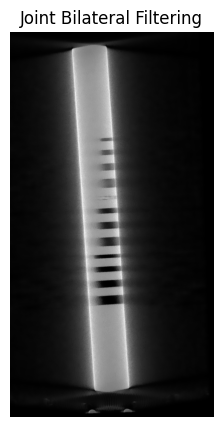

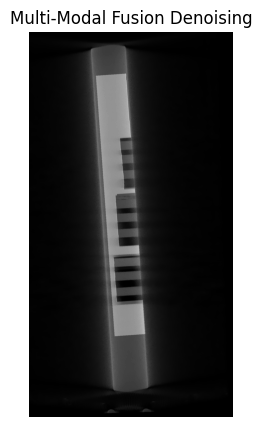

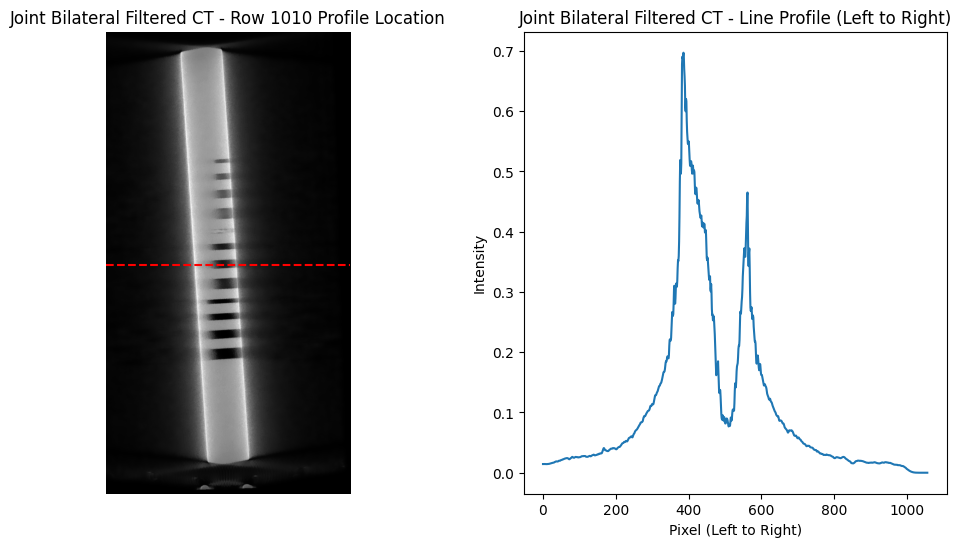

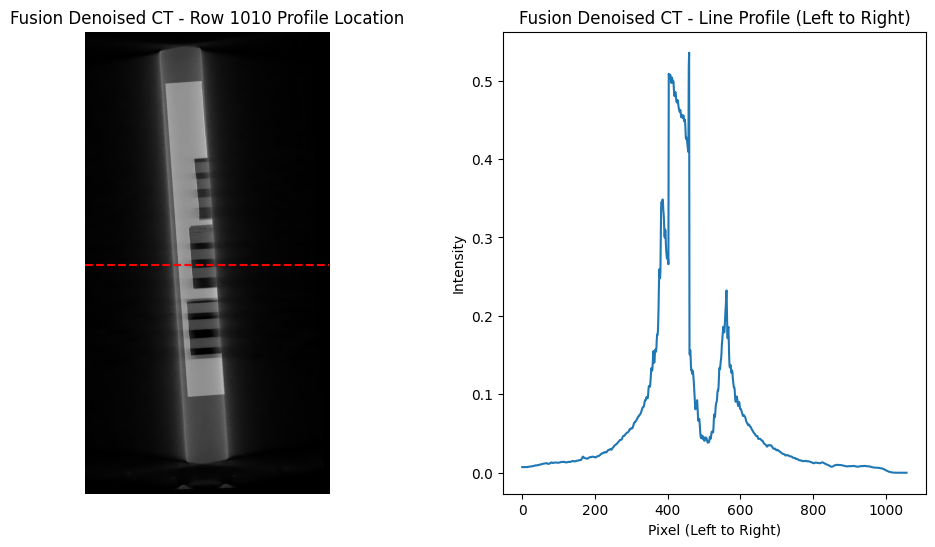

In [3]:
import SimpleITK as sitk
import numpy as np
import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def cast_to_int(image, pixel_type=sitk.sitkUInt16):
    """Cast image to integer type (UInt16) for compatibility with Mask operations."""
    return sitk.Cast(image, pixel_type)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    This returns a 2D image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    # Set the size for the extraction: full in x and y, but only 0 in the z-direction.
    size[2] = 0  
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

# --- Joint Bilateral Filtering ---
def joint_bilateral_filter(ct_image, paut_image, sigma_color=0.05, sigma_space=10):
    """Apply joint bilateral filtering using PAUT as guidance."""
    bilateral_filter = sitk.BilateralImageFilter()
    bilateral_filter.SetDomainSigma(sigma_space)
    bilateral_filter.SetRangeSigma(sigma_color)
    return bilateral_filter.Execute(ct_image)

# --- Multi-Modal Noise Reduction via Fusion ---
def multimodal_fusion_denoising(filtered_ct_image, paut_image):
    """
    Apply wavelet-based noise reduction by fusing PAUT guidance.
    Here, the filtered CT image from the joint bilateral filter is fused with the PAUT slice.
    """
    ct_array = sitk.GetArrayFromImage(filtered_ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    coeffs_ct = pywt.dwtn(ct_array, 'haar')
    coeffs_paut = pywt.dwtn(paut_array, 'haar')
    fused_coeffs = {key: (coeffs_ct[key] + coeffs_paut[key]) / 2 for key in coeffs_ct.keys()}
    denoised_array = pywt.idwtn(fused_coeffs, 'haar')
    return sitk.GetImageFromArray(denoised_array)

# --- Display Function for Filtered Image ---
def display_filtered_image(filtered, title='Filtered Image', save_path=None):
    """Display only the final filtered image (2D slice) and optionally save as PNG."""
    filtered_array = sitk.GetArrayFromImage(filtered)
    plt.figure(figsize=(5,5))
    plt.imshow(filtered_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, row_index=1010, save_path=None):
    """
    Plot the line profile from left to right for the specified row of a 2D image.
    The function overlays a horizontal line on the image at the specified row and
    plots the intensity profile extracted from that row.
    """
    array = sitk.GetArrayFromImage(image)
    # Ensure the row index is within the image bounds
    if row_index >= array.shape[0]:
        raise ValueError("Row index is out of bounds for the given image.")
    
    # Extract the profile along the given row (left to right)
    line_profile = array[row_index, :]

    # Create a figure with two subplots: one showing the image with the profile line and one for the profile plot.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image with the horizontal line at the specified row
    axs[0].imshow(array, cmap='gray')
    axs[0].axhline(y=row_index, color='red', linestyle='--')
    axs[0].set_title(f"{label} - Row {row_index} Profile Location")
    axs[0].axis('off')

    # Plot the intensity profile along that row
    axs[1].plot(line_profile)
    axs[1].set_title(f"{label} - Line Profile (Left to Right)")
    axs[1].set_xlabel("Pixel (Left to Right)")
    axs[1].set_ylabel("Intensity")

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # Assume CT_data and resampled_paut are previously loaded 3D images.
    
    # Normalize full volumes
    ct_normalized = normalize_image(CT_data)
    paut_normalized = normalize_image(resampled_paut)
    
    # Extract middle slice from each volume (2D images)
    ct_slice = extract_middle_slice(ct_normalized)
    paut_slice = extract_middle_slice(paut_normalized)
    
    # Apply joint bilateral filtering first
    bilateral_filtered = joint_bilateral_filter(ct_slice, paut_slice)
    
    # Then apply multi-modal fusion denoising using the bilateral filtered result and PAUT slice
    fusion_filtered = multimodal_fusion_denoising(bilateral_filtered, paut_slice)
    
    # Display final filtered images only and save as PNG
    display_filtered_image(bilateral_filtered, title='Joint Bilateral Filtering', save_path='joint_bilateral_filter.png')
    display_filtered_image(fusion_filtered, title='Multi-Modal Fusion Denoising', save_path='fusion_denoised.png')
    
    # Plot line profiles for original and filtered images and save as PNG files
    plot_line_profile(bilateral_filtered, "Joint Bilateral Filtered CT", save_path='joint_bilateral_line_profile.png')
    plot_line_profile(fusion_filtered, "Fusion Denoised CT", save_path='fusion_denoised_line_profile.png')


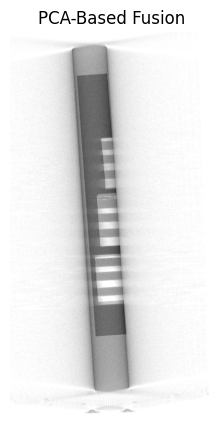

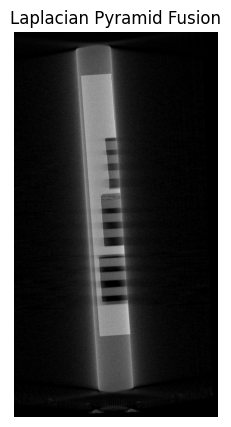

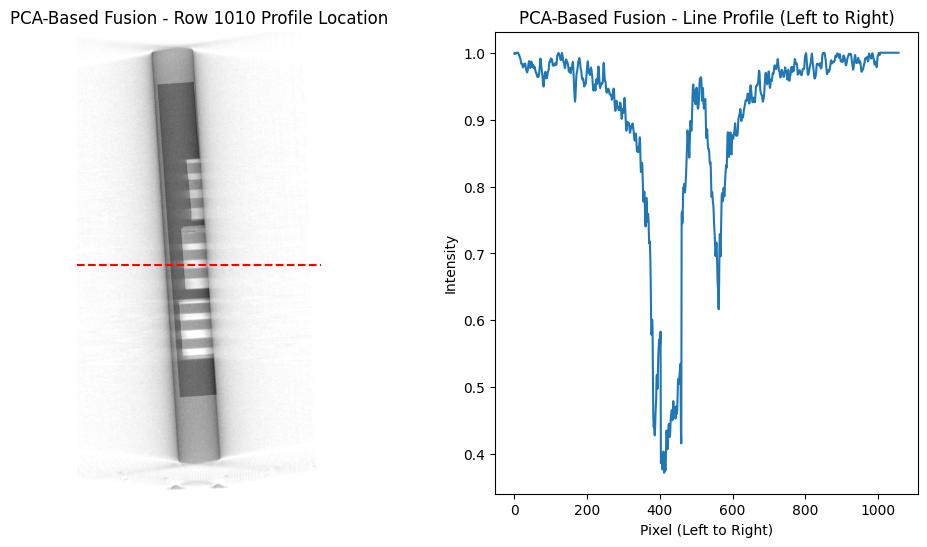

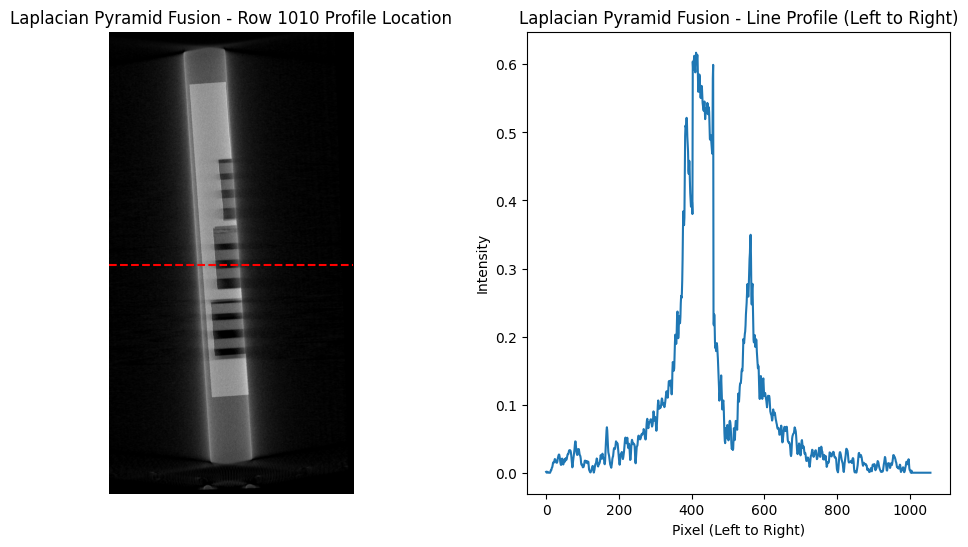

In [3]:
import SimpleITK as sitk
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

def normalize_image(image):
    """Normalize image intensities to range [0,1] and return a SimpleITK image."""
    array = sitk.GetArrayFromImage(image)
    normalized_array = (array - np.min(array)) / (np.max(array) - np.min(array))
    normalized_image = sitk.GetImageFromArray(normalized_array)
    return sitk.Cast(normalized_image, sitk.sitkFloat32)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    Returns a 2D SimpleITK image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    size[2] = 0  # extract only one slice along the z-direction
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

def pca_fusion(ct_image, paut_image):
    """
    Fuse two modalities using a PCA-based approach.
    """
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    pixels = np.stack((ct_array.flatten(), paut_array.flatten()), axis=1)
    mean = np.mean(pixels, axis=0)
    centered = pixels - mean
    cov = np.cov(centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    principal_component = eigvecs[:, np.argmax(eigvals)]
    fused_flat = np.dot(centered, principal_component)
    
    fused_array = fused_flat.reshape(ct_array.shape)
    fused_array = (fused_array - np.min(fused_array)) / (np.max(fused_array) - np.min(fused_array))
    return sitk.GetImageFromArray(fused_array)

def laplacian_pyramid_fusion(ct_image, paut_image, levels=3, sigma=1.0, weight=0.5):
    """
    Fuse two modalities using Laplacian pyramid fusion.
    """
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)

    def gaussian_pyramid(image_array, levels, sigma):
        gp = [image_array]
        for _ in range(1, levels):
            image_array = ndimage.gaussian_filter(image_array, sigma=sigma)
            image_array = image_array[::2, ::2]
            gp.append(image_array)
        return gp

    def laplacian_pyramid(gp):
        lp = []
        for i in range(len(gp) - 1):
            expanded = ndimage.zoom(gp[i + 1], zoom=2, order=1)
            if expanded.shape != gp[i].shape:
                expanded = expanded[:gp[i].shape[0], :gp[i].shape[1]]
            lp.append(gp[i] - expanded)
        lp.append(gp[-1])
        return lp

    def reconstruct_from_laplacian(lp):
        image = lp[-1]
        for l in reversed(lp[:-1]):
            image = ndimage.zoom(image, zoom=2, order=1)
            if image.shape != l.shape:
                image = image[:l.shape[0], :l.shape[1]]
            image = image + l
        return image

    gp_ct = gaussian_pyramid(ct_array, levels, sigma)
    gp_paut = gaussian_pyramid(paut_array, levels, sigma)

    lp_ct = laplacian_pyramid(gp_ct)
    lp_paut = laplacian_pyramid(gp_paut)

    fused_lp = [weight * l_ct + (1 - weight) * l_paut for l_ct, l_paut in zip(lp_ct, lp_paut)]
    
    fused_array = reconstruct_from_laplacian(fused_lp)
    fused_array = (fused_array - np.min(fused_array)) / (np.max(fused_array) - np.min(fused_array))
    return sitk.GetImageFromArray(fused_array)

def display_fused_image(fused, title, save_path=None):
    """Display only the final fused image and optionally save it as PNG."""
    fused_array = sitk.GetArrayFromImage(fused)
    plt.figure(figsize=(5, 5))
    plt.imshow(fused_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, row_index=1010, save_path=None):
    """
    Plot the line profile from left to right for the specified row of a 2D image.
    The function overlays a horizontal line on the image at the specified row and
    plots the intensity profile extracted from that row.
    """
    array = sitk.GetArrayFromImage(image)
    # Ensure the row index is within the image bounds
    if row_index >= array.shape[0]:
        raise ValueError("Row index is out of bounds for the given image.")
    
    # Extract the profile along the given row (left to right)
    line_profile = array[row_index, :]

    # Create a figure with two subplots: one showing the image with the profile line and one for the profile plot.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image with the horizontal line at the specified row
    axs[0].imshow(array, cmap='gray')
    axs[0].axhline(y=row_index, color='red', linestyle='--')
    axs[0].set_title(f"{label} - Row {row_index} Profile Location")
    axs[0].axis('off')

    # Plot the intensity profile along that row
    axs[1].plot(line_profile)
    axs[1].set_title(f"{label} - Line Profile (Left to Right)")
    axs[1].set_xlabel("Pixel (Left to Right)")
    axs[1].set_ylabel("Intensity")

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # Assume CT_data and resampled_paut are pre-loaded 3D SimpleITK images.
    
    # Normalize volumes
    ct_normalized = normalize_image(CT_data)
    paut_normalized = normalize_image(resampled_paut)
    
    # Extract the middle slice from each volume
    ct_slice = extract_middle_slice(ct_normalized)
    paut_slice = extract_middle_slice(paut_normalized)
    
    # Apply fusion methods
    fused_pca = pca_fusion(ct_slice, paut_slice)
    fused_laplacian = laplacian_pyramid_fusion(ct_slice, paut_slice, levels=4, sigma=1.0, weight=0.6)
    
    # Display final fused images and save as PNG
    display_fused_image(fused_pca, title='PCA-Based Fusion', save_path='pca_fusion.png')
    display_fused_image(fused_laplacian, title='Laplacian Pyramid Fusion', save_path='laplacian_fusion.png')

    # Plot line profiles for fused images and save as PNG
    plot_line_profile(fused_pca, "PCA-Based Fusion", save_path='pca_fusion_line_profile.png')
    plot_line_profile(fused_laplacian, "Laplacian Pyramid Fusion", save_path='laplacian_fusion_line_profile.png')
